In [1]:
!pip install -q -U albumentations

In [93]:
!nvidia-smi

Sun Feb 12 17:44:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |  15781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import keras
from tensorflow.keras.layers import Input,Reshape, Lambda, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D,Dropout, Concatenate, Conv2DTranspose, dot, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,VerticalFlip,
    Rotate,GridDistortion,ElasticTransform
)

In [4]:
!pip install tqdm
from tqdm import tqdm

In [5]:
len(os.listdir('../input/512x512-lits-train-images-masks/train_images/train_images'))*0.85

49842.299999999996

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [7]:
transforms = Compose([
        #ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        #GridDistortion(p=0.5),
        #OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
         VerticalFlip(p=0.5),
         HorizontalFlip(p=0.5),
        
])


In [8]:
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize = (8,8))
    img = clahe.apply(img)
    return img

In [28]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]
    
    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('../input/512x512-lits-train-images-masks/train_images/train_images',
                                            '../input/512x512-train-masks/train_masks/train_masks'), train_y))
    X = []
    Y = []
    for i in tqdm(range(len(train_x))):
        temp_mask = read_mask(train_y[i])
        val, counts = np.unique(temp_mask, return_counts=True)
        #print(counts)
        if(len(counts)==3):
            #if (1 - (counts[0]/counts.sum())) > 0.01:
            

            if ((counts[2]/(counts[1]+counts[2])) > 0.01):
                X.append(train_x[i])
                Y.append(train_y[i])
                

    print(len(X))
    print(len(Y))
    train_test_x, valid_x = train_test_split(X, test_size=0.20, random_state=42)
    train_test_y, valid_y = train_test_split(Y, test_size=0.20, random_state=42)
    train_x, test_x = train_test_split(train_test_x, test_size=0.15, random_state=42)
    train_y, test_y = train_test_split(train_test_y, test_size=0.15, random_state=42)
    
    

    return (train_x, train_y), (valid_x, valid_y), (test_x,test_y)


def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(256,256), interpolation = cv2.INTER_AREA)
    b , g, r = cv2.split(x)
    
    b1 = CLAHE(b)
    g1 = CLAHE(g)
    r1 = CLAHE(r)
    x = cv2.merge([b,g,r])
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    x = x / 255.0
    x = x.astype(np.float32)
    #return b,g,r
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(256,256), interpolation = cv2.INTER_AREA)
    x = x.astype(np.int32)
    #mask = tf.one_hot(x, 3, dtype = tf.float32)
    return x


def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset


def preprocess(x,y):
    shape = [256,256,3]
    def aug_fn(image, mask):
        img_data = {"image":image}
        mask_data = {"mask":mask}
        img_data = transforms(**image)
        mask_data = transforms(**mask)
        aug_img = img_data["image"]
        aug_mask = mask_data["mask"]
        return aug_img, aug_mask
    
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        image = read_image(x)
        mask = read_mask(y)
        augmented = transforms(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
#     image, mask = tf.numpy_function(aug_fn,[image, mask],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.float32)
    image.set_shape(shape)
    mask.set_shape(shape)
    
    return image, mask


In [101]:
from tensorflow.keras.applications import VGG19
def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections



In [9]:
from tensorflow.keras.applications import ResNet50

In [25]:
def encoder1(inputs):


    """ Pre-trained ResNet50 Model """
    resnet50= ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    s = []
    for layer in resnet50.layers:
        print(layer.name)
        break
    
    """ Encoder """
    s1 = resnet50.get_layer("input_2").output           ## (512 x 512)
    s.append(s1)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s.append(s2)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s.append(s3)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)
    s.append(s4)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)
    return b1,s

In [11]:

from tensorflow.keras.applications import InceptionResNetV2
def encoder1(inputs):

    
    s = []

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in encoder.layers:
        print(layer.name)

    """ Encoder """
    s1 = encoder.get_layer("input_16").output           ## (512 x 512)
    s.append(s1)

    s2 = encoder.get_layer("activation6").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)
    s.append(s2)

    s3 = encoder.get_layer("activation_36").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)
    s.append(s3)

    s4 = encoder.get_layer("activation_746").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)
    s.append(s4)

    """ Bridge """
    b1 = encoder.get_layer("activation_1616").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)
    
    return b1,s


In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    r = squeeze_excite_block(result_bn)

    return r

def gating_signal(input, out_size):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)
    
def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    #x = squeeze_excite_block(x,8)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x
"""
def decoder_block(inputs, s1,s2, num_filters):
    
    g = gating_signal(inputs,num_filters)
    skip_features = Concatenate()([s1,s2])
    attn = attention_block(skip_features,g,num_filters)
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, attn])
    x = residual_block(x, num_filters)
    #x = squeeze_excite_block(x)
    return x
"""
def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = squeeze_excite_block(x)
    return x

def build_W_Net(input_shape):
    s_1 = []
    f = [32*2,64*2,128*2,256*2]

    inputs = Input(input_shape)

    
    inputs_1 = tf.keras.layers.RandomContrast(0.1)(inputs)
    inputs_1 = tf.keras.layers.RandomZoom(0.2)(inputs_1)
    
    x1,s_1 = encoder1(inputs_1)
    

    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs_1)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs_1)
    
    c1 = x + s
    c1 = squeeze_excite_block(c1)
    p1 = MaxPooling2D((2,2))(c1)
    #s1 = residual_block(c1,f[0])
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    c2 = squeeze_excite_block(c2)
    p2 = MaxPooling2D((2,2))(c2)
    #s2 = residual_block(c2,f[1])
    s2 = c2
    
    c3 = residual_block(p2, f[2])
    c3 = squeeze_excite_block(c3)
    p3 = MaxPooling2D((2,2))(c3)
    #s3 = residual_block(c3,f[2])
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = squeeze_excite_block(c4)
    p4 = MaxPooling2D((2,2))(c4)
    #s4 = residual_block(c4,f[3])
    s4 = c4

    """ Bridge """
    b1 = ASPP(p4,128)
    b2 = ASPP(x1,128)
    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4,s_1[3], f[3])
    d2 = decoder_block(d1, s3,s_1[2], f[2])
    d3 = decoder_block(d2, s2,s_1[1], f[1])
    d4 = decoder_block(d3, s1,s_1[0],f[0])

    """ Classifier """
    outputs = Conv2D(3, (1,1) , activation="softmax")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [11]:
def iou_liver(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    targets_f = K.flatten(targets[:,:,:,1])
    inputs_f = K.flatten(inputs[:,:,:,1])
    
    
    intersection = K.sum((targets_f*inputs_f))
    total = K.sum(targets_f) + K.sum(inputs_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def iou_tumor(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    targets_f = K.flatten(targets[:,:,:,2])
    inputs_f = K.flatten(inputs[:,:,:,2])
    
    intersection = K.sum((targets_f * inputs_f))
    total = K.sum(targets_f) + K.sum(inputs_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

def iou(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    class_num = 3
    for i in range(class_num):
        targets_f= K.flatten(targets[:,:,:,i])
        inputs_f = K.flatten(inputs[:,:,:,i])
       

        intersection = K.sum((targets_f*inputs_f))
        total = K.sum(targets_f) + K.sum(inputs_f)
        union = total - intersection
        loss = (intersection + smooth) / (union + smooth)
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 3
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss
def dice_coef_liver(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return loss

def dice_coef_tumor(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    return loss

# Computing Sensitivity      
def sensitivity_liver(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true[:,:,:,1] * y_pred[:,:,:,1], 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true[:,:,:,1], 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def sensitivity_tumor(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true[:,:,:,2] * y_pred[:,:,:,2], 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true[:,:,:,2], 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity_liver(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true[:,:,:,1]) * (1-y_pred[:,:,:,1]), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true[:,:,:,1], 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def specificity_tumor(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true[:,:,:,2]) * (1-y_pred[:,:,:,2]), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true[:,:,:,2], 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def tversky(y_true, y_pred):
    smooth=1
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return (3 - tversky(y_true[:,:,:,0],y_pred[:,:,:,0])-tversky(y_true[:,:,:,1],y_pred[:,:,:,1])-tversky(y_true[:,:,:,2],y_pred[:,:,:,2]))

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true[:,:,:,0],y_pred[:,:,:,0])
    pt_2 = tversky(y_true[:,:,:,1],y_pred[:,:,:,1])
    pt_3 = tversky(y_true[:,:,:,2],y_pred[:,:,:,2])
    
    gamma = 0.75
    return K.pow((3-pt_1-pt_2-pt_3), gamma)


In [12]:
!pip install -U segmentation-models
#%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
dice_loss = sm.losses.DiceLoss(class_weights = [0.33,0.33,0.33]) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 792.2 kB/s eta 0:00:00:--:--
Segmentation Models: using `keras` framework.


In [17]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [13]:
if __name__ == "__main__":
    
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    
    """ Dataset """
    train_frame_path = '../input/512x512-lits-train-images-masks/train_images/train_images'
    train_mask_path = '../input/512x512-train-masks/train_masks/train_masks'
    
    (train_x, train_y), (valid_x, valid_y),(test_x, test_y) = load_data(train_frame_path, train_mask_path)
    print(len(train_x))
    print(len(valid_x))
    print(len(test_x))
   

100%|██████████| 58638/58638 [13:27<00:00, 72.59it/s]

5740
5740
3903
1148
689


In [14]:
print(len(train_x))
print(len(valid_x))
print(len(test_x))

3903
1148
689


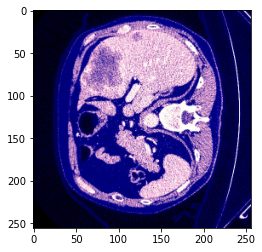

[0 1 2]
(256, 256)


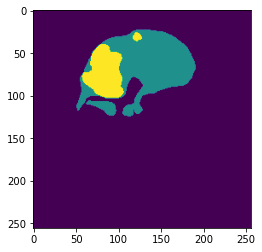

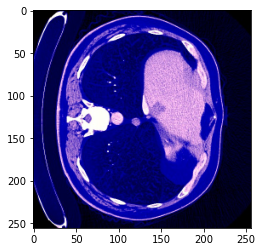

[0 1 2]
(256, 256)


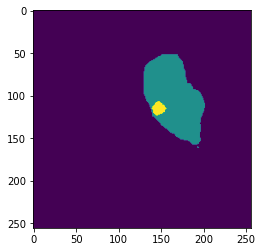

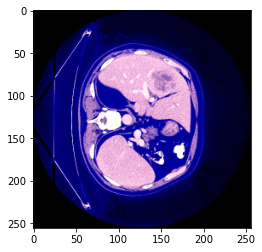

[0 1 2]
(256, 256)


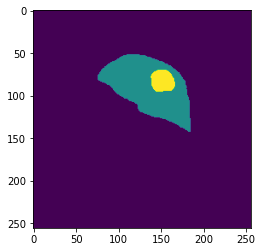

In [20]:
for i in range (len(train_x)//1000):
    mask = read_mask(train_y[i])
    image = read_image(train_x[i])
    plt.imshow(image)
    plt.show()
    plt.imshow(mask)
    print(np.unique(mask))
    print(mask.shape)
    plt.show()

In [19]:
#hyperparameters
shape = (256,256,3)
classes = 3
lr = 1e-3
batch_size = 8
epochs = 100
    
""" Model """
model = build_W_Net(shape)
model.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(lr), metrics = [dice_coef,dice_coef_liver,dice_coef_tumor,iou,iou_liver,iou_tumor,sensitivity,sensitivity_liver,sensitivity_tumor,specificity,specificity_liver,specificity_tumor] )
    
train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)
    
train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size
    
history_class = LossHistory()

In [20]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('./training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001,
                               patience=6, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = './model_wt.h5',
                              verbose=1, save_best_only=True),
      csv_logger
    ]

In [47]:
    history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose = 1
    )
    
    model.save('./final_model7.h5')

Epoch 1/100
487/487 [==============================] - 274s 476ms/step - loss: 0.7330 - dice_coef: 0.8303 - dice_coef_liver: 0.8668 - dice_coef_tumor: 0.6341 - iou: 0.7404 - iou_liver: 0.7662 - iou_tumor: 0.4747 - sensitivity: 0.9781 - sensitivity_liver: 0.8847 - sensitivity_tumor: 0.6328 - specificity: 0.9893 - specificity_liver: 0.9893 - specificity_tumor: 0.9965 - val_loss: 0.7717 - val_dice_coef: 0.7320 - val_dice_coef_liver: 0.7252 - val_dice_coef_tumor: 0.4932 - val_iou: 0.6221 - val_iou_liver: 0.5751 - val_iou_tumor: 0.3348 - val_sensitivity: 0.9565 - val_sensitivity_liver: 0.7297 - val_sensitivity_tumor: 0.4969 - val_specificity: 0.9789 - val_specificity_liver: 0.9820 - val_specificity_tumor: 0.9955

Epoch 00001: val_loss improved from inf to 0.77166, saving model to ./model_wt.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
487/487 [==============================] - 225s 456ms/step - loss: 0.7242 - dice_coef: 0.8539 - dice_coef_liver: 0.8860 - dice_coef_tumor: 0.6843 - iou: 0.7693 - iou_liver: 0.7962 - iou_tumor: 0.5284 - sensitivity: 0.9815 - sensitivity_liver: 0.9001 - sensitivity_tumor: 0.6795 - specificity: 0.9909 - specificity_liver: 0.9912 - specificity_tumor: 0.9970 - val_loss: 0.7287 - val_dice_coef: 0.8396 - val_dice_coef_liver: 0.8450 - val_dice_coef_tumor: 0.6856 - val_iou: 0.7465 - val_iou_liver: 0.7331 - val_iou_tumor: 0.5297 - val_sensitivity: 0.9765 - val_sensitivity_liver: 0.8762 - val_sensitivity_tumor: 0.6478 - val_specificity: 0.9885 - val_specificity_liver: 0.9874 - val_specificity_tumor: 0.9978

Epoch 00002: val_loss improved from 0.77166 to 0.72871, saving model to ./model_wt.h5
Epoch 3/100
487/487 [==============================] - 223s 459ms/step - loss: 0.7160 - dice_coef: 0.8756 - dice_coef_liver: 0.9009 - dice_coef_tumor: 0.7331 - iou: 0.7975 - iou_liver: 0.8204 - io

In [53]:
import os
os.chdir('/kaggle/working')

In [54]:
from IPython.display import FileLink

In [57]:
FileLink(r'final_model7.h5')

/kaggle/working/final_model7.h5

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

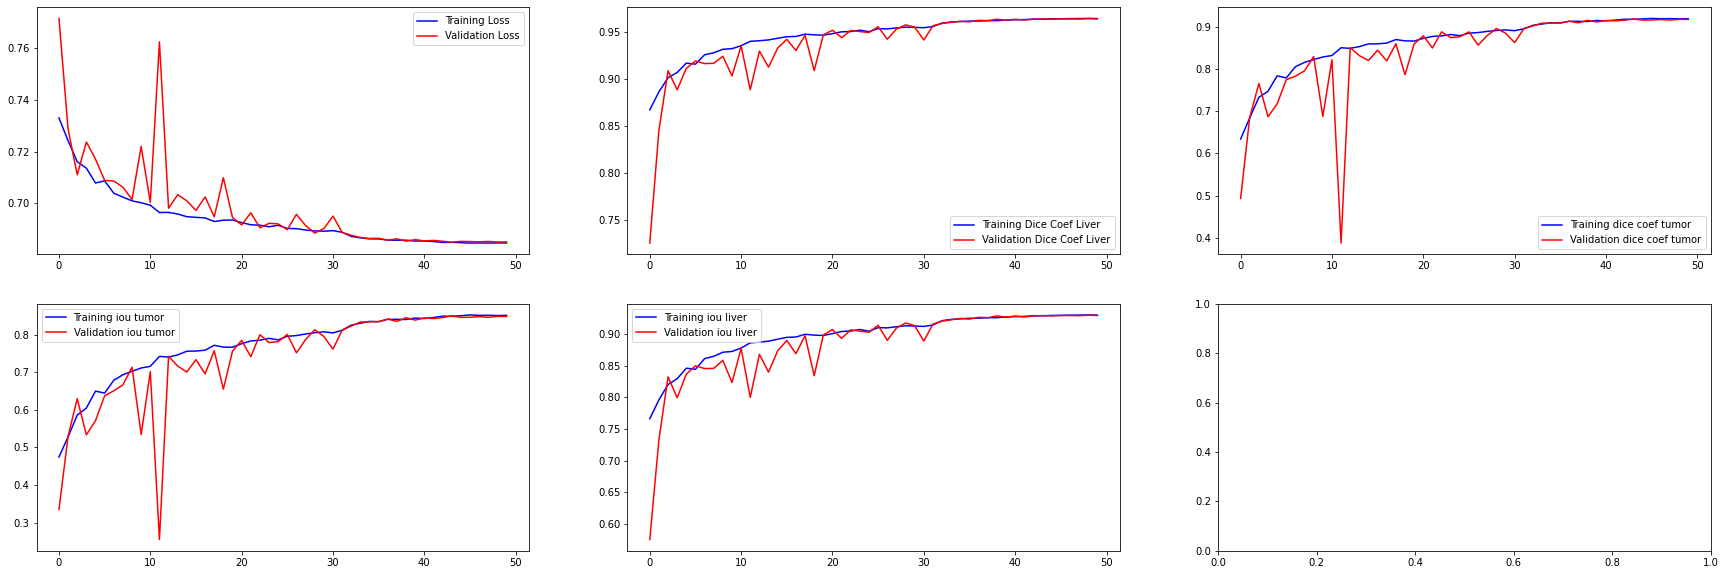

In [66]:
history = pd.read_csv('/kaggle/input/lits17-wnet-resnet-50/training (2).log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history


dice_coef_liver=hist['dice_coef_liver']
val_dice_coef_liver=hist['val_dice_coef_liver']

epoch=range(len(dice_coef_liver))



loss=hist['loss']
val_loss=hist['val_loss']

dice_coef_tumor=hist['dice_coef_tumor']
val_dice_coef_tumor=hist['val_dice_coef_tumor']

iou_tumor=hist['iou_tumor']
val_iou_tumor=hist['val_iou_tumor']

iou_liver=hist['iou_liver']
val_iou_liver=hist['val_iou_liver']

f,ax=plt.subplots(2,3,figsize=(30,10))

ax[0,0].plot(epoch,loss,'b',label='Training Loss')
ax[0,0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0,0].legend()

ax[0,1].plot(epoch,dice_coef_liver,'b',label='Training Dice Coef Liver')
ax[0,1].plot(epoch,val_dice_coef_liver,'r',label='Validation Dice Coef Liver')
ax[0,1].legend()

ax[0,2].plot(epoch,dice_coef_tumor,'b',label='Training dice coef tumor')
ax[0,2].plot(epoch,val_dice_coef_tumor,'r',label='Validation dice coef tumor')
ax[0,2].legend()

ax[1,0].plot(epoch,iou_tumor,'b',label='Training iou tumor')
ax[1,0].plot(epoch,val_iou_tumor,'r',label='Validation iou tumor')
ax[1,0].legend()

ax[1,1].plot(epoch,iou_liver,'b',label='Training iou liver')
ax[1,1].plot(epoch,val_iou_liver,'r',label='Validation iou liver')
ax[1,1].legend()


plt.show()

In [22]:
test_dataset = tf_dataset(test_x, test_y, batch = 8)

In [33]:
model = keras.models.load_model('/kaggle/input/lits17-wnet-resnet-50/final_model7.h5', 
                                   custom_objects={"dice_coef": dice_coef,
                                                   "dice_coef_tumor": dice_coef_tumor,
                                                   "dice_coef_liver": dice_coef_liver,
                                                   "iou_tumor": iou_tumor,
                                                   "iou_liver": iou_liver,
                                                   "sensitivity":sensitivity,
                                                   "sensitivity_tumor":sensitivity_tumor,
                                                   "sensitivity_liver":sensitivity_liver,
                                                   "specificity":specificity,
                                                   "specificity_tumor":specificity_tumor,
                                                   "specificity_liver":specificity_liver,
                                                   
                                                  }, compile=False)

In [24]:
test_steps = len(test_x)//batch_size

In [35]:
print("Evaluate on test data")
model.compile(loss=total_loss, optimizer=tf.keras.optimizers.Adam(0.0001), metrics = [dice_coef,dice_coef_liver,dice_coef_tumor,iou,iou_liver,iou_tumor,sensitivity,sensitivity_liver,sensitivity_tumor,specificity,specificity_liver,specificity_tumor] )
results = model.evaluate(test_dataset, batch_size=8, callbacks= callbacks,steps = test_steps)


In [30]:
image = read_image(test_x[1])

In [31]:
image.shape

(256, 256, 3)

(256, 256, 3)
1/1 [==============================] - 0s 48ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

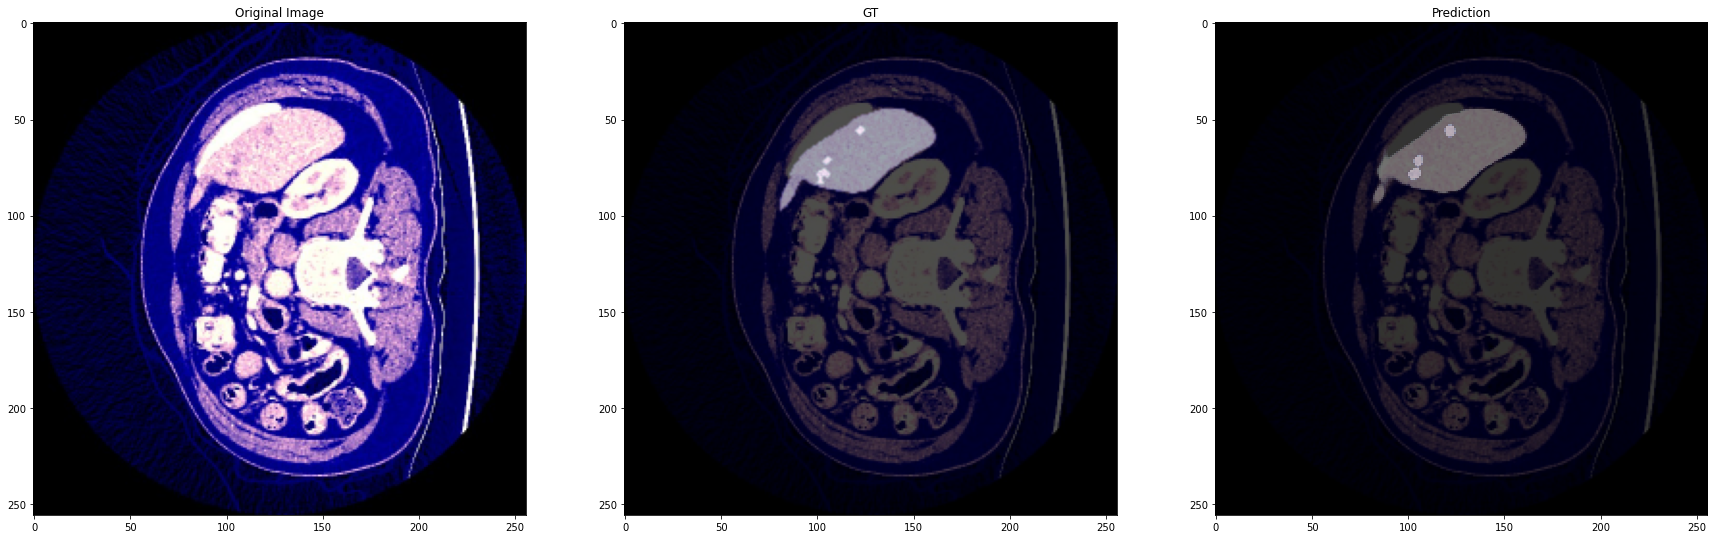

(256, 256, 3)
1/1 [==============================] - 0s 46ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

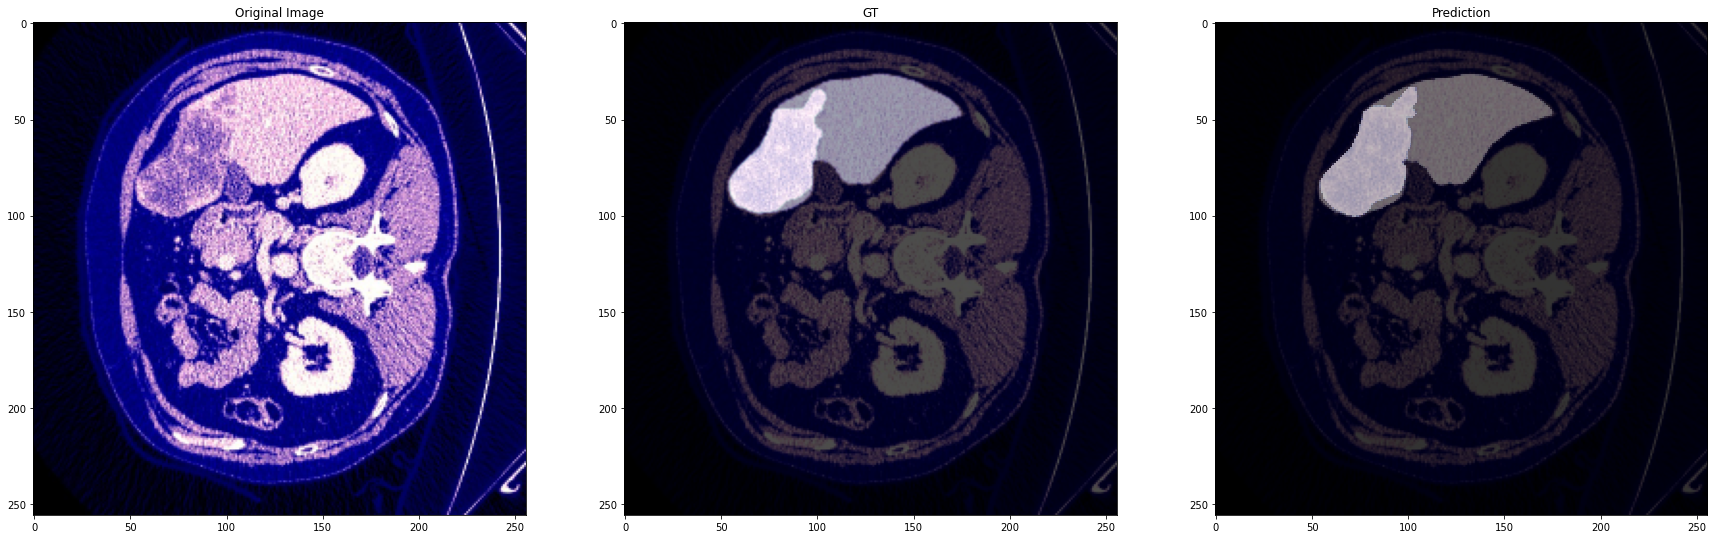

(256, 256, 3)
1/1 [==============================] - 0s 47ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

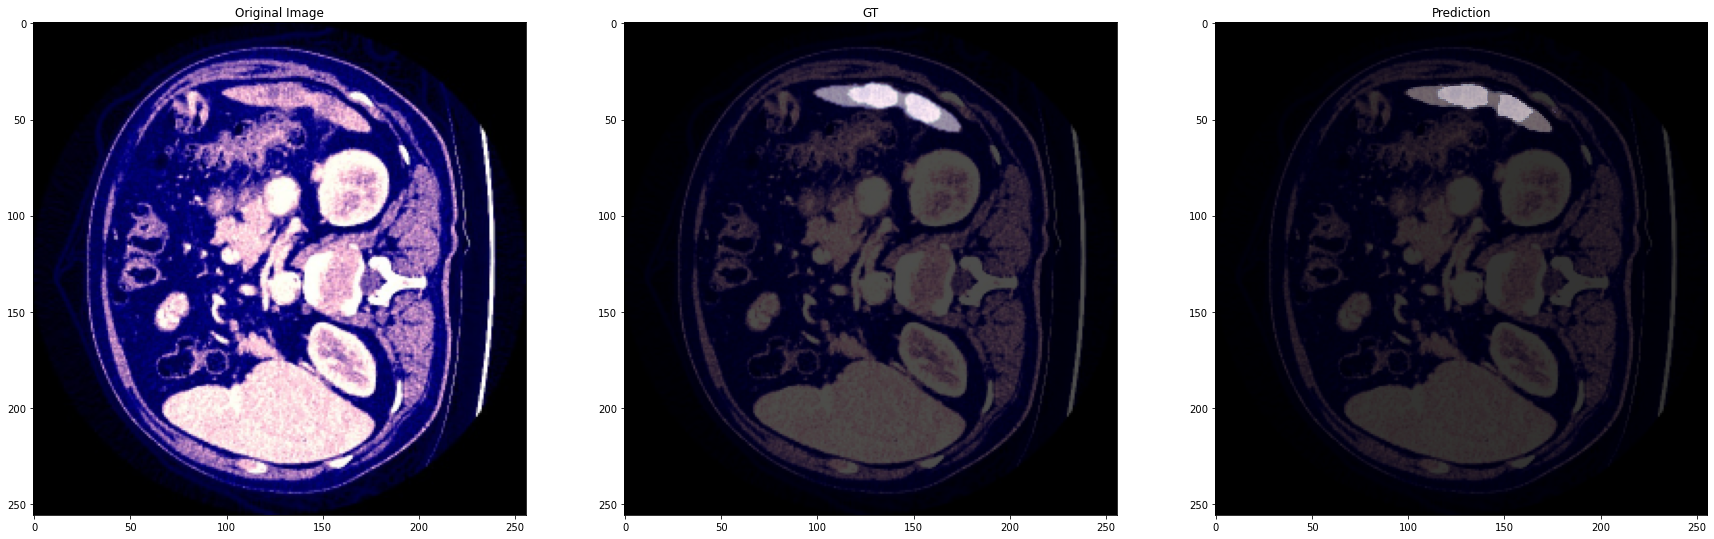

(256, 256, 3)
1/1 [==============================] - 0s 49ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

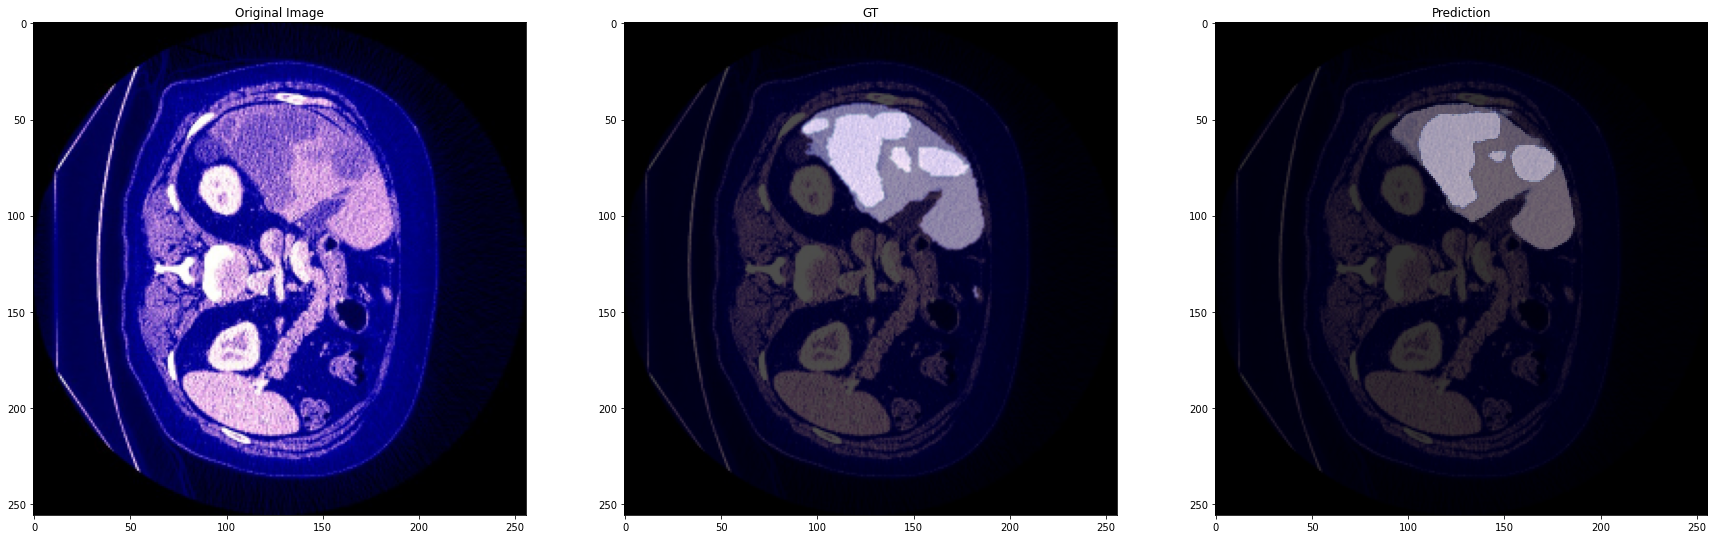

(256, 256, 3)
1/1 [==============================] - 0s 46ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

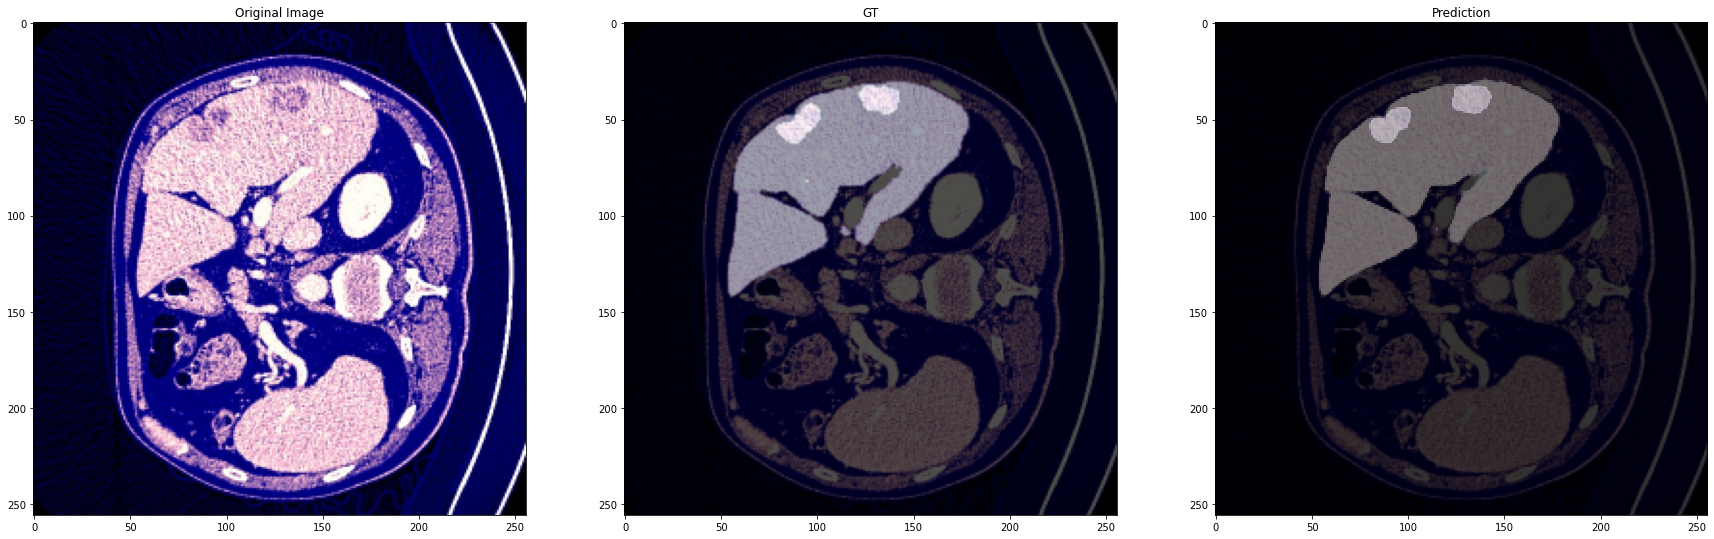

(256, 256, 3)
1/1 [==============================] - 0s 47ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

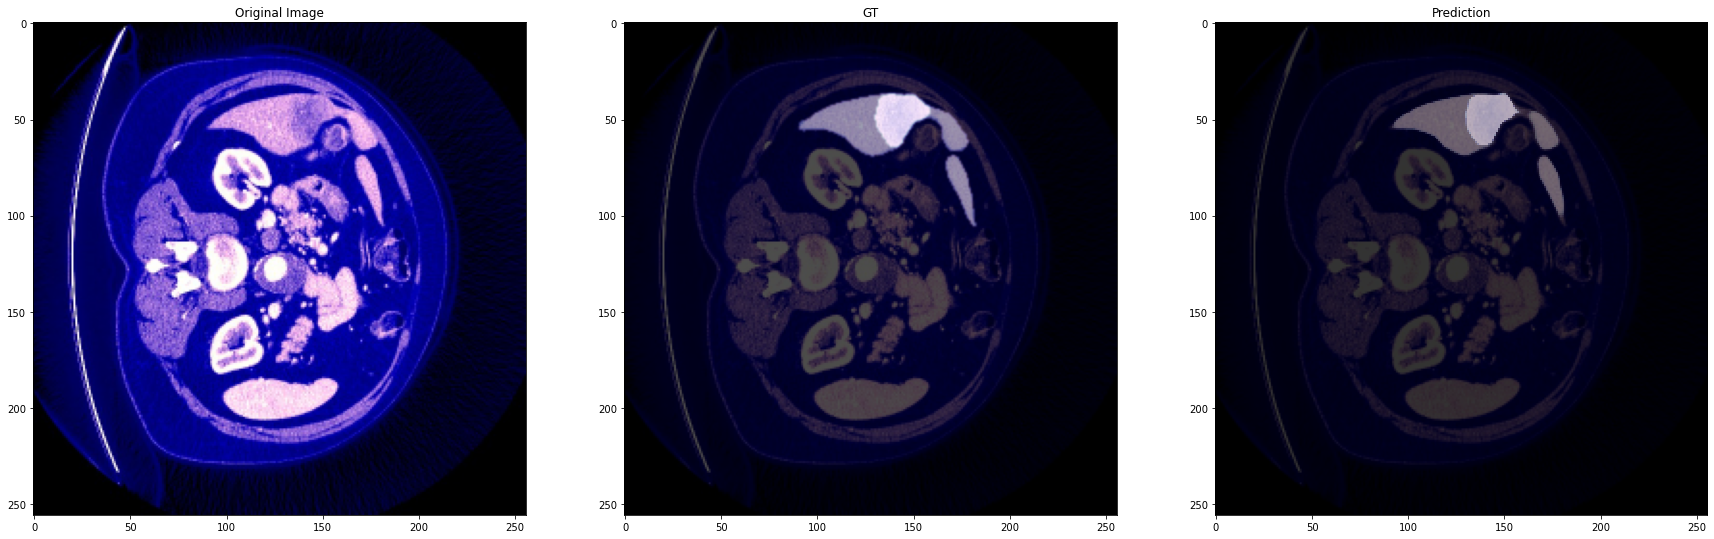

(256, 256, 3)
1/1 [==============================] - 0s 48ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

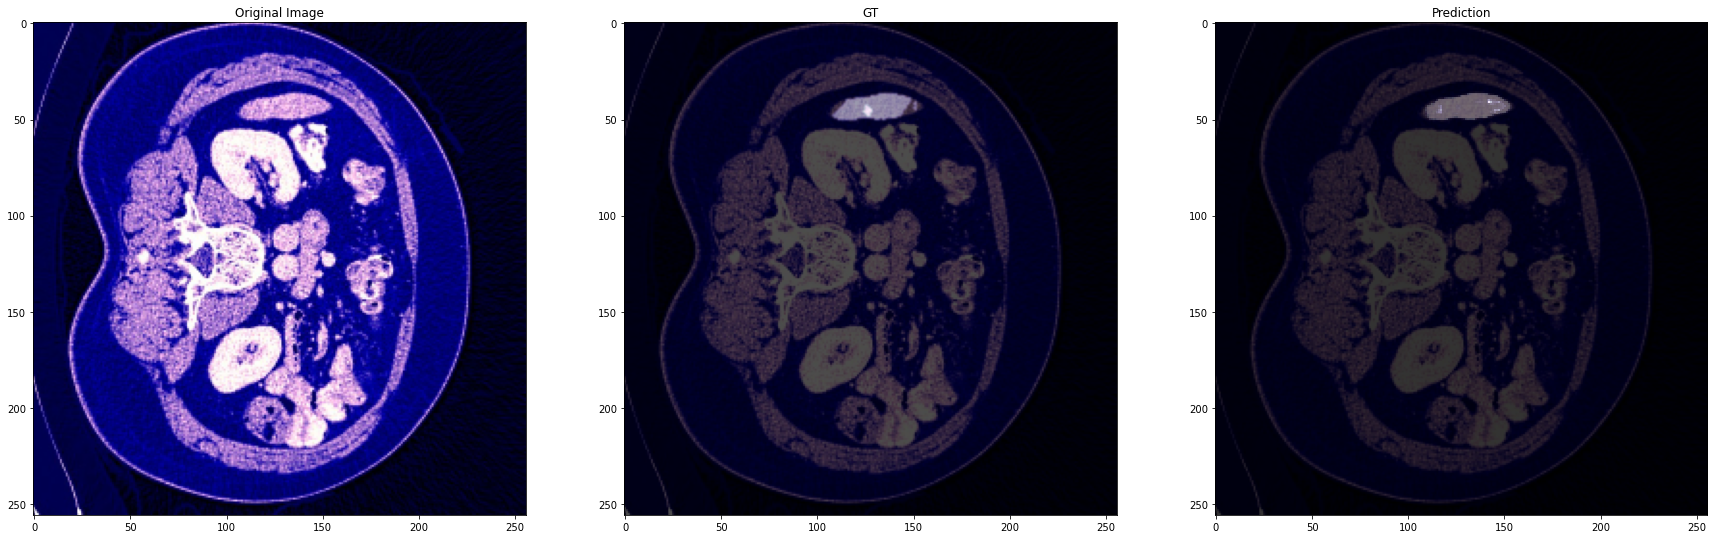

(256, 256, 3)
1/1 [==============================] - 0s 46ms/step
(1, 256, 256, 3)


<Figure size 2160x2160 with 0 Axes>

In [ ]:
def predictByPath(im_path,mask_path):
    
    cmap = 'bone'
    a = 0.7
    inter = 'bicubic'
  
    image = read_image(im_path)
    image_=np.expand_dims(image,axis=0)
    print(image.shape)
    mask = read_mask(mask_path)
    pred = model.predict(image_,verbose=1)
    
    pred[pred>0.5]
    print(pred.shape)
    pred = np.squeeze(pred,axis=0)

    plt.figure(figsize=(30,30))
    f, axarr = plt.subplots(1,3, figsize = (30,30)) 

    for i in range(3): # for each image, add brain background
        axarr[i].imshow(image)
    
    axarr[0].imshow(image, cmap="bone")
    axarr[0].title.set_text('Original Image')
    axarr[1].imshow( mask , interpolation= inter,cmap = cmap, alpha=a)
    axarr[1].title.set_text('GT')
    axarr[2].imshow(pred[:,:,1],interpolation= 'none',cmap = cmap, alpha=0.55)
    axarr[2].imshow(pred[:,:,2],interpolation= 'none',cmap = cmap, alpha=0.55)
    axarr[2].title.set_text('Prediction')
    plt.show()
    
for i in range (20,30):    
    predictByPath(test_x[i],test_y[i])
